# 编程作业四 神经网络

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.io import loadmat
import matplotlib.cm as cm
import random
import scipy.io
from PIL import Image

In [2]:
data=loadmat('ex4data1.mat')
data
X=data['X']
y=data['y']
X=np.insert(X,0,1,axis=1)
X.shape ,y.shape

((5000, 401), (5000, 1))

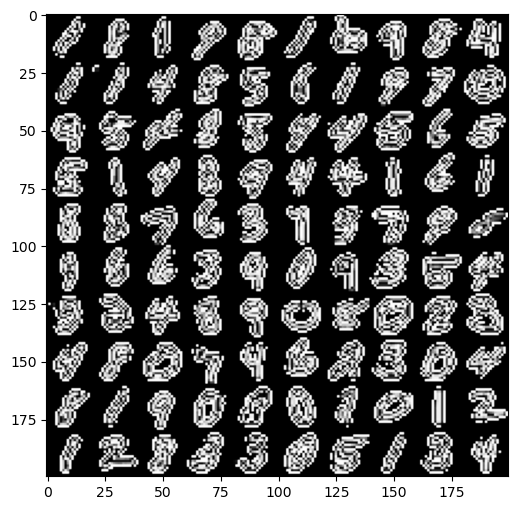

In [3]:
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    creates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width, height)
    return square.T

def displayData(indices_to_display=None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows * ncols)

    big_picture = np.zeros((height * nrows, width * ncols))

    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow * height:irow * height + iimg.shape[0], icol * width:icol * width + iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6, 6))
    img = Image.fromarray((big_picture * 255).astype(np.uint8))
    plt.imshow(img, cmap=cm.Greys_r)

displayData()

我们也需要对我们的y标签进行一次one-hot 编码。 one-hot 编码将类标签n（k类）转换为长度为k的向量，其中索引n为“hot”（1），而其余为0。 Scikitlearn有一个内置的实用程序，我们可以使用这个。

In [4]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_onehot_sparse = encoder.fit_transform(y)
y_onehot = y_onehot_sparse.toarray()

In [5]:
y_onehot[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [6]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

# 向前传播

In [7]:
def forward_propagate(X,theta1,theta2):
    m=X.shape[0]
    a1=np.insert(X,0,values=np.ones(m),axis=1)
    z2=a1*theta1.T
    a2=np.insert(sigmoid(z2),0,values=np.ones(m),axis=1)
    z3=a2*theta2.T
    h=sigmoid(z3)
    return a1,z2,a2,z3,h

# 代价函数

In [8]:
def cost(params,input_size,hidden_size,num_labels,X,y,lamda):
    m=X.shape[0]
    X=np.matrix(X)
    y=np.matrix(y)

    #从params中获取神经网络参数，并按照输入层维度和隐藏层维度重新定义参数的维度
    theta1=np.matrix(np.reshape(params[:hidden_size*(input_size+1)],(hidden_size,(input_size+1))))
    theta2=np.matrix(np.reshape(params[hidden_size*(input_size+1):],(num_labels,(hidden_size+1))))

    # 调用向前传播函数
    a1,z2,a2,z3,h=forward_propagate(X,theta1,theta2)

    #初始化代价函数
    J=0

    #根据公式计算代价函数
    for i in range(m):
        
        first_term=np.multiply(-y[i,:],np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J+=np.sum(first_term-second_term)

    J=J/m

    J+=(float(lamda)/(2*m))*(np.sum(np.power(theta1[:,1:],2)) + np.sum(np.power(theta2[:,1:], 2)))

    return J

In [9]:
# 初始化设置
input_size = 400
hidden_size = 25
num_labels = 10
lamda = 0.3
X=data['X']
y=data['y']

# 随机初始化完整网络参数大小的参数数组
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25

m = X.shape[0]
X = np.matrix(X)
y = np.matrix(y)

# 将参数数组解开为每个层的参数矩阵
theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

theta1.shape, theta2.shape

y.shape

(5000, 1)

In [10]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

In [11]:
cost(params, input_size, hidden_size, num_labels, X, y_onehot, lamda)


6.7117147456258675

反向传播所需的计算是代价函数中所需的计算过程，我们实际上将扩展代价函数以执行反向传播并返回代价和梯度。

In [12]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z),1-sigmoid(z))

In [13]:
def backprop(params, input_size, hidden_size, num_labels, X, y, lamda):
    m=X.shape[0]
    X= np.matrix(X)
    y = np.matrix(y)

    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    a1, z2, a2, z3, h =forward_propagate(X, theta1, theta2)
    
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)

    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)

    J = J / m

    #实现反向传播算法
    for t in range(m):  #遍历每个样本
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)   z3t=z3[t:]  (1,10)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)

        #反向传播算法梯度的计算
        d3t = ht - yt
        z2t = np.insert(z2t, 0, values=np.ones(1)) # (1, 26) 
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t  #我觉得这一步有问题，z3没有求导，应该乘以sigmoid_gradient(z3t)

    # 加入正则化
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * lamda) / m
    delta2[:,1:] =  delta2[:,1:] + (theta2[:,1:] * lamda) / m
    
    # 将梯度矩阵转换为单个数组
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad



反向传播计算的最难的部分（除了理解正在做所有这些计算）是获得正确矩阵维度。 容易混淆了A * B与np.multiply（A，B）使用。 基本上前者是矩阵乘法，后者是元素乘法（除非A或B是标量值，在这种情况下没关系）。

In [14]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, lamda)
J, grad.shape

(6.71010817568794, (10285,))

# 训练好网络之后，进行预测

In [15]:
from scipy.optimize import minimize

# minimize the objective function
fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, lamda), 
                method='TNC', jac=True, options={'maxiter': 250})
fmin

C:\Users\haoda\AppData\Local\Temp\ipykernel_39980\1461412643.py:4: OptimizeWarning: Unknown solver options: maxiter
  fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, lamda),
C:\Users\haoda\AppData\Local\Temp\ipykernel_39980\1539055575.py:17: RuntimeWarning: divide by zero encountered in log
  second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
C:\Users\haoda\AppData\Local\Temp\ipykernel_39980\1539055575.py:17: RuntimeWarning: invalid value encountered in multiply
  second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))


 message: Linear search failed
 success: False
  status: 4
     fun: 0.22363140790894132
       x: [ 3.741e-01 -8.785e-02 ... -2.522e-02  2.305e-01]
     nit: 17
     jac: [-2.688e-01 -5.271e-06 ... -8.861e+00 -1.512e+01]
    nfev: 313

In [16]:
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)  #选取概率最大的
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=int64)

In [17]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 97.88%
